In [1]:
import torch
from torchvision.datasets import CIFAR10
from torch.utils.data import random_split, DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import random
from sklearn.cluster import KMeans
import numpy as np
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
import numpy as np
from typing import List, Tuple
import pickle
import time
from torch.utils.data import ConcatDataset, Dataset, Subset
%matplotlib inline
plt.rcParams['figure.figsize'] = [5, 5]

In [2]:
train_dataset = CIFAR10('D:/downloads/btp/outputforpaper/CIFAR10', train=True, download=True, transform=transforms.ToTensor())
test_dataset = CIFAR10('D:/downloads/btp/outputforpaper/CIFAR10', train=False, download=True, transform=transforms.ToTensor())

Files already downloaded and verified
Files already downloaded and verified


In [3]:
total_train_size = len(train_dataset)
total_test_size = len(test_dataset)
classes = 10
input_dim = 784
num_clients = 10
rounds = 30
batch_size = 32
in_group_rounds=3
epochs_per_client =10
learning_rate = 2e-2
num_malicious_clients=5

In [4]:
def get_device():
    return torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader(DataLoader):
        def __init__(self, dl, device):
            self.dl = dl
            self.device = device

        def __iter__(self):
            for batch in self.dl:
                yield to_device(batch, self.device)

        def __len__(self):
            return len(self.dl)

device = get_device()


def average_models(new_model, next, scale):
    if new_model == None:
        new_model = next
        for key in new_model:
            new_model[key] = new_model[key] * scale
    else:
        for key in new_model:
            new_model[key] = new_model[key] + (next[key] * scale)
    return new_model

In [5]:
class FederatedNet(torch.nn.Module):    
    def __init__(self):
        super().__init__()
        # Update input channels to 3 for RGB images
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(3, 16, kernel_size=5, padding=2),
            torch.nn.BatchNorm2d(16),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2))
        
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(16, 32, kernel_size=5, padding=2),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2))
        
        self.fc = torch.nn.Linear(8 * 8 * 32, 10)
    
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out
    
    def batch_accuracy(self, outputs, labels):
        with torch.no_grad():
            _, predictions = torch.max(outputs, dim=1)
            return torch.tensor(torch.sum(predictions == labels).item() / len(predictions))
    
    def _process_batch(self, batch):
        images, labels = batch
        outputs = self(images)
        loss = torch.nn.functional.cross_entropy(outputs, labels)
        accuracy = self.batch_accuracy(outputs, labels)
        return (loss, accuracy)
    
    def fit(self, dataset, epochs, lr, batch_size=128, opt=torch.optim.SGD):
        dataloader = DeviceDataLoader(DataLoader(dataset, batch_size, shuffle=True), device)
        optimizer = opt(self.parameters(), lr)
        history = []
        for epoch in range(epochs):
            losses = []
            accs = []
            for batch in dataloader:
                loss, acc = self._process_batch(batch)
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
                loss.detach()
                losses.append(loss)
                accs.append(acc)
            avg_loss = torch.stack(losses).mean().item()
            avg_acc = torch.stack(accs).mean().item()
            history.append((avg_loss, avg_acc))
        return history
    
    def evaluate(self, dataset, batch_size=128):
        dataloader = DeviceDataLoader(DataLoader(dataset, batch_size), device)
        losses = []
        accs = []
        with torch.no_grad():
            for batch in dataloader:
                loss, acc = self._process_batch(batch)
                losses.append(loss)
                accs.append(acc)
        avg_loss = torch.stack(losses).mean().item()
        avg_acc = torch.stack(accs).mean().item()
        return (avg_loss, avg_acc)

In [6]:
def partition_data_label_quantity(
    num_clients, labels_per_client, train_dataset,total_train_size,seed=42):
    trainset=train_dataset
    prng = np.random.default_rng(seed)

    targets = trainset.targets
    if isinstance(targets, list):
        targets = np.array(targets)
    if isinstance(targets, torch.Tensor):
        targets = targets.numpy()
    num_classes = len(set(targets))
    times = [0 for _ in range(num_classes)]
    contains = []

    for i in range(num_clients):
        current = [i % num_classes]
        times[i % num_classes] += 1
        j = 1
        while j < labels_per_client:
            index = prng.choice(num_classes, 1)[0]
            if index not in current:
                current.append(index)
                times[index] += 1
                j += 1
        contains.append(current)
    idx_clients: List[List] = [[] for _ in range(num_clients)]
    for i in range(num_classes):
        idx_k = np.where(targets == i)[0]
        prng.shuffle(idx_k)
        idx_k_split = np.array_split(idx_k, times[i])
        ids = 0
        for j in range(num_clients):
            if i in contains[j]:
                idx_clients[j] += idx_k_split[ids].tolist()
                ids += 1
    trainsets_per_client = [Subset(trainset, idxs) for idxs in idx_clients]
    return trainsets_per_client

In [7]:
client_datasets = partition_data_label_quantity(num_clients,2,train_dataset,len(train_dataset))

In [8]:
import numpy as np


class memory:

    def __init__(self, batch_number, batch_size):
        self.batch_number = batch_number
        self.batch_size = batch_size
        self.matrix = np.zeros((batch_number, batch_size), dtype=int)
        self.add_time = 0

    def add_number(self, batch_no, true_array):
        if batch_no >= self.batch_number:
            print(f"Warning: Batch number {batch_no} out of range. Skipping this entry.")
            return
        # Ensure true_array length matches batch_size by padding or truncating as necessary
        true_array = np.pad(true_array, (0, max(0, self.batch_size - len(true_array))), mode='constant')[:self.batch_size]
        self.matrix[batch_no] += true_array


    def add(self):
        self.add_time = self.add_time + 1

    def get_ambiguous(self, number):
        temp_matrix = self.matrix
        temp_matrix = np.abs(temp_matrix - np.ones(self.matrix.shape) * self.add_time * 0.5)
        temp_array = np.reshape(temp_matrix, self.matrix.shape[0] * self.matrix.shape[1])
        temp = list(map(list, zip(range(len(temp_array)), temp_array)))
        small = sorted(temp, key=lambda x: x[1], reverse=False)
        small_array = []
        for i in range(number):
            small_array.append(small[i][0])
        return small_array

In [9]:
from torch.utils.data import DataLoader
import torch
from torch import nn
import numpy as np
# import dnn_model  # Assumed custom DNN model import
# from memory import memory  # Assumed memory module import


class KMT:
    learning_rate = 0.01
    momentum = 0.5
    batch_size = 32
    batch_number = 1000
    train_loss = []
    test_loss = []
    test_accuracy = []

    def __init__(self, dataset, index, test_loader):
        # Load training set and initialize test loader
        self.load_train_set(dataset, index)
        self.test_loader = test_loader
        self.model = FederatedNet()  # Use FederatedNet model here
        self.criterion = nn.CrossEntropyLoss()
        self.distillation_criterion = nn.KLDivLoss(reduction='batchmean')
        self.optimizer = torch.optim.SGD(self.model.parameters(), lr=self.learning_rate, momentum=self.momentum)
        self.memory = memory(self.batch_number, self.batch_size)

    def load_train_set(self, dataset, index):
        # Subset and DataLoader for training
        train_dataset = torch.utils.data.Subset(dataset, index.astype(int))
        self.train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)

    def train(self):
        # Standard training without distillation
        self.memory.add()  # Initialize memory
        running_loss = 0
        batch_number = 0

        for images, labels in self.train_loader:
            self.optimizer.zero_grad()
            output = self.model(images)
            loss = self.criterion(output, labels)

            # Accuracy calculation for memory tracking
            log_ps = torch.log_softmax(output, dim=1)
            ps = torch.exp(log_ps)
            top_p, top_class = ps.topk(1, dim=1)
            equals = (top_class == labels.view(*top_class.shape)).numpy().squeeze().astype(int).transpose()
            self.memory.add_number(batch_number, equals)

            # Backpropagation and optimizer step
            loss.backward()
            self.optimizer.step()
            running_loss += loss.item()
            batch_number += 1

        self.train_loss.append(running_loss / len(self.train_loader))

    def distillation_train(self, images, labels, other_soft_decision):
        # Knowledge distillation training with soft labels from other clients
        self.optimizer.zero_grad()
        output = self.model(images)
        loss1 = self.criterion(output, labels)
        loss2 = self.distillation_criterion(torch.log_softmax(output, dim=1), other_soft_decision)
        loss = loss1 + loss2

        log_ps = torch.log_softmax(output, dim=1)
        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = (top_class == labels.view(*top_class.shape)).numpy().squeeze().astype(int).transpose()

        # Backpropagation and optimizer step
        loss.backward()
        self.optimizer.step()
        return equals

    def test(self):
        accuracy = 0
        loss = 0
        for images, labels in self.test_loader:
            output = self.model(images)
            log_ps = torch.log_softmax(output, dim=1)
            ps = torch.exp(log_ps)
            loss += self.criterion(log_ps, labels)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.view(*top_class.shape)
            accuracy += torch.mean(equals.type(torch.FloatTensor))
        self.test_loss.append((loss / len(self.test_loader)).item())
        self.test_accuracy.append((accuracy / len(self.test_loader)).item())
        return accuracy / len(self.test_loader)

    def save_model(self, filename="temp_model.pt"):
        torch.save(self.model.state_dict(), filename)

    def load_model(self, filename="temp_model.pt"):
        self.model.load_state_dict(torch.load(filename))

    def get_ambiguous_data(self, array):
        np.sort(array)
        batch_number = 0
        ambiguous_images = []
        ambiguous_labels = []
        for images, labels in self.train_loader:
            for no in array:
                if int(no / self.batch_size) == batch_number:
                    column = np.mod(no, self.batch_size)
                    ambiguous_images.append(images[column])
                    ambiguous_labels.append(labels[column])
            batch_number += 1
        ambiguous_images = torch.stack(ambiguous_images)
        ambiguous_labels = torch.stack(ambiguous_labels)
        return ambiguous_images, ambiguous_labels

    def test_data(self, images, labels):
        loss = 0
        output = self.model(images)
        log_ps = torch.log_softmax(output, dim=1)
        loss += self.criterion(log_ps, labels)
        return loss

    def test_data_accuracy(self, images, labels):
        output = self.model(images)
        log_ps = torch.log_softmax(output, dim=1)
        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy = torch.mean(equals.type(torch.FloatTensor))
        return accuracy


DFL

In [10]:
class Client:
    def __init__(self, client_id, dataset, test_loader):
        self.client_id = client_id
        self.dataset = dataset
        # self.test_loader = test_loader
        self.kmt = KMT(dataset, index=np.arange(len(dataset)), test_loader=test_loader)
        self.client_data = []

    def get_dataset_size(self):
        return len(self.dataset)
    
    def get_client_id(self):
        return self.client_id

    def train(self, parameters_dict, other_soft_decisions=None):
        # Load initial parameters
        self.kmt.model.load_state_dict(parameters_dict)

        # Standard training
        self.kmt.train()

        # Knowledge distillation using soft labels from other clients (if available)
        if other_soft_decisions is not None:
            for images, labels in self.kmt.train_loader:
                if images in other_soft_decisions:
                    other_soft_decision = other_soft_decisions[images]
                    self.kmt.distillation_train(images, labels, other_soft_decision)
        
        # Return the updated model parameters
        return self.kmt.model.state_dict()

    def recieve_parameters(self, client_id, client_parameter, fraction):
        client_object = {"client_id": client_id, "client_parameter": client_parameter, "fraction": fraction}
        self.client_data.append(client_object)

    def aggregated_parameters(self):
        local_aggregated_model = None
        for i in range(len(self.client_data)):
            local_aggregated_model = average_models(local_aggregated_model, self.client_data[i]["client_parameter"], self.client_data[i]["fraction"])
        self.client_data.clear()
        return local_aggregated_model


In [11]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=200, shuffle=True)
clients = [Client(i, client_datasets[i], test_loader) for i in range(num_clients)]

In [12]:
dfl_start_time = time.time()

global_net = to_device(FederatedNet(), device)
curr_parameters = global_net.state_dict()
history_dfl = []
weights = []
traffic = []
load_model = None
total_data_size = len(train_dataset)

for i in range(rounds):
    new_model = None
    soft_decisions = {}  # Dictionary to store each client's soft decisions for distillation

    # Step 1: Each client performs training and generates soft decisions
    for client in clients:
        fraction = client.get_dataset_size() / total_data_size

        # Each client trains on its dataset, possibly using other clients' soft decisions for distillation
        client_parameters = client.train(curr_parameters, other_soft_decisions=soft_decisions if i > 0 else None)
        
        # Gather soft decisions for this client's data to use in distillation
        for images, labels in client.kmt.train_loader:
            output = client.kmt.model(images)
            soft_decisions[images] = torch.softmax(output, dim=1).detach()

        # Share parameters with other clients for aggregation
        for clt in clients:
            clt.recieve_parameters(client.get_client_id(), client_parameters, fraction)

        # Aggregate models across all clients
        new_model = average_models(new_model, client_parameters, fraction)

    # Update the global model and evaluate
    load_model = new_model.copy()
    global_net.load_state_dict(new_model)
    train_loss, train_acc = global_net.evaluate(train_dataset)
    dev_loss, dev_acc = global_net.evaluate(test_dataset)
    
    # Logging
    print(f'After round {i + 1}, train_loss = {round(train_loss, 4)}, dev_loss = {round(dev_loss, 4)}, dev_acc = {round(dev_acc, 4)}')
    history_dfl.append((train_acc, dev_acc, i))
    traffic.append((num_clients) * (num_clients - 1))

# Calculate total time
dfl_end_time = time.time()
dfl_time = dfl_end_time - dfl_start_time
print(f"Total training time: {dfl_time:.2f} seconds")

# Optionally save the final global model if needed
torch.save(global_net.state_dict(), "final_global_model.pt")

After round 1, train_loss = 2.3189, dev_loss = 2.3203, dev_acc = 0.1509
After round 2, train_loss = 1.988, dev_loss = 1.9873, dev_acc = 0.2694
After round 3, train_loss = 1.875, dev_loss = 1.8767, dev_acc = 0.2911
After round 4, train_loss = 1.7639, dev_loss = 1.7679, dev_acc = 0.3683
After round 5, train_loss = 1.6791, dev_loss = 1.6841, dev_acc = 0.4072
After round 6, train_loss = 1.6472, dev_loss = 1.6546, dev_acc = 0.4062
After round 7, train_loss = 1.6062, dev_loss = 1.614, dev_acc = 0.4174
After round 8, train_loss = 1.5597, dev_loss = 1.5717, dev_acc = 0.4417
After round 9, train_loss = 1.5534, dev_loss = 1.567, dev_acc = 0.4385
After round 10, train_loss = 1.5076, dev_loss = 1.5246, dev_acc = 0.4602
After round 11, train_loss = 1.5009, dev_loss = 1.5198, dev_acc = 0.455
After round 12, train_loss = 1.4698, dev_loss = 1.493, dev_acc = 0.4634
After round 13, train_loss = 1.4434, dev_loss = 1.4667, dev_acc = 0.4746
After round 14, train_loss = 1.4741, dev_loss = 1.4981, dev_acc = 

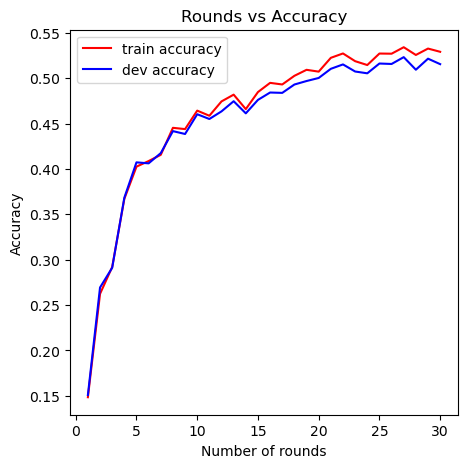

In [13]:
plt.plot([i + 1 for i in range(len(history_dfl))], [history_dfl[i][0] for i in range(len(history_dfl))], color='r', label='train accuracy')
plt.plot([i + 1 for i in range(len(history_dfl))], [history_dfl[i][1] for i in range(len(history_dfl))], color='b', label='dev accuracy')
plt.legend()
plt.title("Rounds vs Accuracy")
plt.xlabel("Number of rounds")
plt.ylabel("Accuracy")
plt.show()

HDFL

In [14]:
class Client:
    def __init__(self, client_id, dataset, test_loader):
        self.client_id = client_id
        self.dataset = dataset
        self.kmt = KMT(dataset, index=np.arange(len(dataset)), test_loader=test_loader)
        self.client_data=[]
        self.server_id=-1
        self.distance=random.randint(1,100)

    def set_server_id(self,client_id):
        self.client_data_server=[]
        self.server_id=client_id
    
    def get_server_id(self):
        return self.server_id

    def get_dataset_size(self):
        return len(self.dataset)
    
    def get_client_id(self):
        return self.client_id

    def train(self, parameters_dict, other_soft_decisions=None):
        # Load initial parameters
        self.kmt.model.load_state_dict(parameters_dict)

        # Standard training
        self.kmt.train()

        # Knowledge distillation using soft labels from other clients (if available)
        if other_soft_decisions is not None:
            for images, labels in self.kmt.train_loader:
                if images in other_soft_decisions:
                    other_soft_decision = other_soft_decisions[images]
                    self.kmt.distillation_train(images, labels, other_soft_decision)
        
        # Return the updated model parameters
        return self.kmt.model.state_dict()

    def recieve_parameters(self, client_id, client_parameter, fraction):
        client_object = {"client_id": client_id, "client_parameter": client_parameter, "fraction": fraction}
        self.client_data.append(client_object)

    def aggregated_parameters(self):
        local_aggregated_model = None
        for i in range(len(self.client_data)):
            local_aggregated_model = average_models(local_aggregated_model, self.client_data[i]["client_parameter"], self.client_data[i]["fraction"])
        self.client_data.clear()
        return local_aggregated_model
    
    def recieve_data_as_server(self,client_parameter,fraction):
        client_object={"client_parameter":client_parameter,"fraction":fraction}
        self.client_data_server.append(client_object)
    

    def aggregate_parameter_as_server(self):
         local_aggregated_model_as_server=None
         for data in self.client_data_server:
              local_aggregated_model_as_server=average_models(local_aggregated_model_as_server,data["client_parameter"],data["fraction"])
         self.client_data_server.clear()
         return local_aggregated_model_as_server


In [15]:
def utility_function(client_set_1,client_set_2,data):
  client_set_1_average=None
  client_set_2_average=None
  for i in client_set_1:
    client_set_1_average=average_models(client_set_1_average,data[i],1)
  for i in client_set_2:
    client_set_2_average=average_models(client_set_2_average,data[i],1)
  model1_weights = []
  model2_weights = []
  for key, value in client_set_1_average.items():
      model1_weights.append(value.detach().cpu())

  for key, value in client_set_2_average.items():
      model2_weights.append(value.detach().cpu())
  weight1_flat = torch.cat([param.view(-1) for param in model1_weights])
  weight2_flat = torch.cat([param.view(-1) for param in model2_weights])
  cosine_sim = torch.nn.functional.cosine_similarity(weight1_flat, weight2_flat, dim=0)
  return cosine_sim.item()

In [16]:
def generateGroupsGame(data,num_clients):
    groups=[]
    for i in range(0,num_clients):
        groups.append([i])
    while True:
        for group in groups:
            for x in group:
                no_change_flag=0
                m_i_n_group=None
                m_i_n_utility=100
                minu=0
                for g in groups:
                    if g!=group:
                        if len(g) >= 1 and len(group) > 1:
                            tempset_1=g.copy()
                            tempset_1.append(x)
                            tempset_2=group.copy()
                            tempset_2.remove(x)
                            if utility_function(tempset_1,tempset_2,data) > utility_function(g,group,data): 
                                if minu < utility_function(tempset_1,tempset_2,data):
                                    m_i_n_group=g
                                    minu=utility_function(tempset_1,tempset_2,data)        
                        elif len(group)<=1:
                            if utility_function(g,group,data) < m_i_n_utility:
                                m_i_n_group=g
                                m_i_n_utility=utility_function(g,group,data)
                if m_i_n_group is not None:  
                    group.remove(x)
                    m_i_n_group.append(x)
                    no_change_flag=1
                    if len(group) <=0 :
                        groups.remove(group)
        if no_change_flag == 0:
            break
    print("end")
    return groups

In [17]:
def groupDataLength(groups,clients):
    group_dataset_length=[]
    for grp in groups:
        totalcount=0
        for clt in grp:
            totalcount+=clients[clt].get_dataset_size()
        group_dataset_length.append(totalcount)
    return group_dataset_length

In [18]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=200, shuffle=True)
clients = [Client(i, client_datasets[i], test_loader) for i in range(num_clients)]

In [19]:
global_net = to_device(FederatedNet(), device)
curr_parameters = global_net.state_dict()
data = []
for client in clients:
    paramerter=client.train(curr_parameters)
    data.append(paramerter)

groups=generateGroupsGame(data,num_clients)
print(groups)
group_dataset_length=groupDataLength(groups,clients)

end
[[4, 5, 0, 2], [6, 3, 9], [8, 7, 1]]


In [20]:
hdfl_start_time = time.time()

global_net = to_device(FederatedNet(), device)
curr_parameters = global_net.state_dict()
history_hdfl = []
weights = []
traffic = []
load_model = None
total_data_size = len(train_dataset)

for i in range(rounds):
    new_model = None
    soft_decisions = {}  # Dictionary to store each client's soft decisions for distillation

    # Step 1: Each client performs training and generates soft decisions
    for client in clients:
        fraction = client.get_dataset_size() / total_data_size

        # Each client trains on its dataset, possibly using other clients' soft decisions for distillation
        client_parameters = client.train(curr_parameters, other_soft_decisions=soft_decisions if i > 0 else None)
        
        # Gather soft decisions for this client's data to use in distillation
        for images, labels in client.kmt.train_loader:
            output = client.kmt.model(images)
            soft_decisions[images] = torch.softmax(output, dim=1).detach()

        # Share parameters with other clients for aggregation
        for clt in clients:
            clt.recieve_parameters(client.get_client_id(), client_parameters, fraction)

        # Aggregate models across all clients
        new_model = average_models(new_model, client_parameters, fraction)

    # Update the global model and evaluate
    load_model = new_model.copy()
    global_net.load_state_dict(new_model)
    train_loss, train_acc = global_net.evaluate(train_dataset)
    dev_loss, dev_acc = global_net.evaluate(test_dataset)
    
    # Logging
    print(f'After round {i + 1}, train_loss = {round(train_loss, 4)}, dev_loss = {round(dev_loss, 4)}, dev_acc = {round(dev_acc, 4)}')
    history_hdfl.append((train_acc, dev_acc, i))
    traffic.append((num_clients) * (num_clients - 1))

# Calculate total time
hdfl_end_time = time.time()
hdfl_time = hdfl_end_time - hdfl_start_time
print(f"Total training time: {hdfl_time:.2f} seconds")

# Optionally save the final global model if needed
torch.save(global_net.state_dict(), "final_global_model.pt")


After round 1, train_loss = 2.2344, dev_loss = 2.2375, dev_acc = 0.1843
After round 2, train_loss = 1.9853, dev_loss = 1.9863, dev_acc = 0.2749
After round 3, train_loss = 1.8923, dev_loss = 1.8976, dev_acc = 0.3153
After round 4, train_loss = 1.796, dev_loss = 1.803, dev_acc = 0.3394
After round 5, train_loss = 1.724, dev_loss = 1.7314, dev_acc = 0.3782
After round 6, train_loss = 1.7011, dev_loss = 1.7083, dev_acc = 0.3783
After round 7, train_loss = 1.6291, dev_loss = 1.6402, dev_acc = 0.4088
After round 8, train_loss = 1.5994, dev_loss = 1.6119, dev_acc = 0.4216
After round 9, train_loss = 1.5555, dev_loss = 1.5695, dev_acc = 0.4366
After round 10, train_loss = 1.5605, dev_loss = 1.5765, dev_acc = 0.4291
After round 11, train_loss = 1.5361, dev_loss = 1.5539, dev_acc = 0.4381
After round 12, train_loss = 1.5002, dev_loss = 1.5186, dev_acc = 0.4494
After round 13, train_loss = 1.5087, dev_loss = 1.5294, dev_acc = 0.442
After round 14, train_loss = 1.4579, dev_loss = 1.4777, dev_acc 

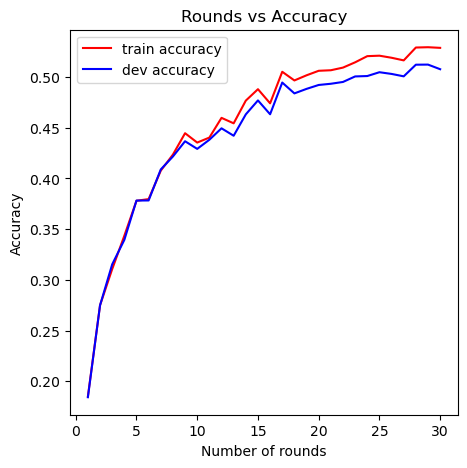

In [21]:
plt.plot([i + 1 for i in range(len(history_hdfl))], [history_hdfl[i][0] for i in range(len(history_hdfl))], color='r', label='train accuracy')
plt.plot([i + 1 for i in range(len(history_hdfl))], [history_hdfl[i][1] for i in range(len(history_hdfl))], color='b', label='dev accuracy')
plt.legend()
plt.title("Rounds vs Accuracy")
plt.xlabel("Number of rounds")
plt.ylabel("Accuracy")
plt.show()

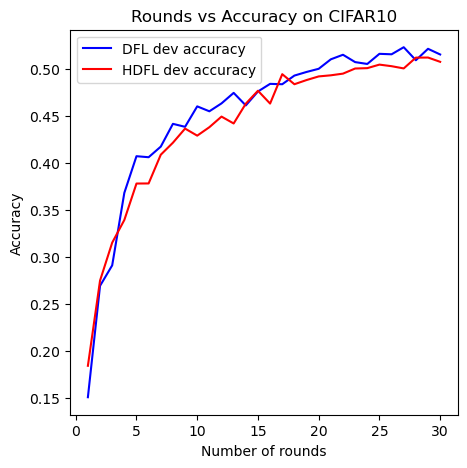

In [24]:
plt.plot([i + 1 for i in range(len(history_dfl))], [history_dfl[i][1] for i in range(len(history_dfl))], color='b', label='DFL dev accuracy')
plt.plot([i + 1 for i in range(len(history_hdfl))], [history_hdfl[i][1] for i in range(len(history_hdfl))], color='r', label='HDFL dev accuracy')
plt.legend()
plt.title("Rounds vs Accuracy on CIFAR10")
plt.xlabel("Number of rounds")
plt.ylabel("Accuracy")
plt.show()

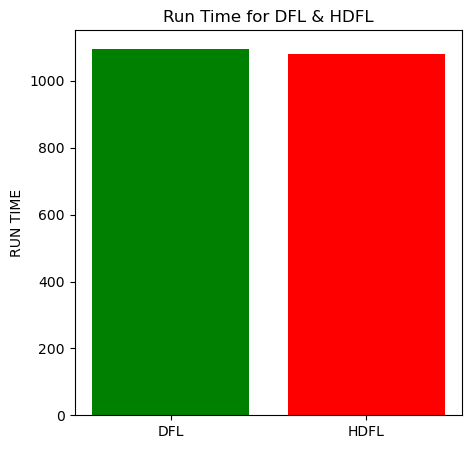

In [23]:
labels = ['DFL', 'HDFL']
values = [dfl_time, hdfl_time]

# Plot the bar graph
plt.bar(labels, values, color=['green', 'red'])

# Add labels and title
plt.xlabel('')
plt.ylabel('RUN TIME')
plt.title('Run Time for DFL & HDFL')

# Show the plot
plt.show()